In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1 = pd.read_csv("class1.txt",delimiter=' ', header=None)
df2 = pd.read_csv("class2.txt",delimiter=' ', header=None)
df3 = pd.read_csv("class3.txt",delimiter=' ', header=None)

In [ ]:
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True).drop(2, axis=1)
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True).drop(2, axis=1)
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True).drop(2, axis=1)

In [ ]:
df1_train = df1[:int(len(df1)*0.7)]
df1_test = df1[int(len(df1)*0.7):]
df2_train = df2[:int(len(df2)*0.7)]
df2_test = df2[int(len(df2)*0.7):]
df3_train = df3[:int(len(df3)*0.7)]
df3_test = df3[int(len(df3)*0.7):]
print(len(df1_train))
print(len(df1_test))

1717
737


## MEAN

In [ ]:
def means(df):
    means = {}
    for col in df.columns:
        means[col] = sum(df[col]) / len(df[col])
    return means

In [ ]:
means1 = means(df1_train)
means2 = means(df2_train)
means3 = means(df3_train)

In [ ]:
print(means1)
print(means2)
print(means3)

{0: 483.6265106290041, 1: 853.0845042224811}
{0: 360.9253841183228, 1: 755.3534247558874}
{0: 425.4035402370555, 1: 2087.475144260761}


## CENTERED DATA

In [ ]:
def centered_data(df, means):
    centered_data = {}
    for col in df.columns:
        centered_data[col] = [value - means[col] for value in df[col]]
    return centered_data

In [ ]:
centered_data1 = centered_data(df1_train, means1)
centered_data2 = centered_data(df2_train, means2)
centered_data3 = centered_data(df3_train, means3)

## COVARIANCE MATRIX

In [ ]:
def covariance_matrix(df,centered_data):
  n = len(df)
  cov_matrix= {}
  for col1 in df.columns:
    cov_matrix[col1] = {}
    for col2 in df.columns:
        cov = sum(centered_data[col1][i] * centered_data[col2][i] for i in range(n)) / (n - 1)
        cov_matrix[col1][col2] = cov
  cov_matrix_df = pd.DataFrame(cov_matrix)
  return cov_matrix_df

In [ ]:
cov_matrix_1 = covariance_matrix(df1_train,centered_data1)
cov_matrix_2 = covariance_matrix(df2_train,centered_data2)
cov_matrix_3 = covariance_matrix(df3_train,centered_data3)
print(cov_matrix_1)
print(cov_matrix_2)
print(cov_matrix_3)
cov_matrix_all=(cov_matrix_3+cov_matrix_2+cov_matrix_1)/3
cov_matrix_all

             0             1
0  8512.678873   5891.512618
1  5891.512618  13448.669287
             0            1
0  4001.527486  3379.865629
1  3379.865629  7601.174914
             0             1
0  7881.726635   1975.508498
1  1975.508498  25757.413286


,0,1
0,6798.644331,3748.962248
1,3748.962248,15602.419162


In [ ]:
def covariance_matrix_d(df,centered_data):  #diagonal covariance matrix
  n = len(df)
  cov_matrix= {}
  for col1 in df.columns:
    cov_matrix[col1] = {}
    for col2 in df.columns:
        if col1 == col2:
          cov = sum(centered_data[col1][i] * centered_data[col2][i] for i in range(n)) / (n - 1)
          cov_matrix[col1][col2] = cov
        else:
          cov_matrix[col1][col2] = 0
  cov_matrix_df = pd.DataFrame(cov_matrix)
  return cov_matrix_df

In [ ]:
cov_matrix_1_d = covariance_matrix_d(df1_train,centered_data1)
cov_matrix_2_d = covariance_matrix_d(df2_train,centered_data2)
cov_matrix_3_d = covariance_matrix_d(df3_train,centered_data3)
print(cov_matrix_1_d)
print(cov_matrix_2_d)
print(cov_matrix_3_d)
cov_matrix_all_d=(cov_matrix_3_d+cov_matrix_2_d+cov_matrix_1_d)/3
print(cov_matrix_all_d)

             0             1
0  8512.678873      0.000000
1     0.000000  13448.669287
             0            1
0  4001.527486     0.000000
1     0.000000  7601.174914
             0             1
0  7881.726635      0.000000
1     0.000000  25757.413286
             0             1
0  6798.644331      0.000000
1     0.000000  15602.419162


##PRIOR

In [ ]:
total_len = len(df1_train) + len(df2_train) + len(df3_train)
priors = {
    'class1': len(df1_train) / total_len,
    'class2': len(df2_train) / total_len,
    'class3': len(df3_train) / total_len
}

print(priors)

{'class1': 0.33926101560956334, 'class2': 0.3440031614305473, 'class3': 0.31673582295988933}


## LIKELIHOOD

In [ ]:
def calculate_likelihood(x, means, cov_matrix):
    x = np.array(x)
    mu = np.array([means[col] for col in means.keys()])
    sigma_inv = np.linalg.inv(cov_matrix)
    sigma_det = np.linalg.det(cov_matrix)
    d = len(x)  # Number of dimensions

    # Compute the term (x - mu).T * Sigma_inv * (x - mu)
    diff = x - mu
    exponent = -0.5 * np.dot(np.dot(diff.T, sigma_inv), diff)

    # Compute the coefficient (1 / sqrt((2 * pi)^d * |Sigma|))
    coefficient = 1 / np.sqrt((2 * np.pi) ** d * sigma_det)

    # Compute the likelihood
    likelihood = coefficient * np.exp(exponent)
    return likelihood

## EVIDENCE

In [ ]:
class_stats = { #covariance matrix is full and different
    'class1': (means1, cov_matrix_1),
    'class2': (means2, cov_matrix_2),
    'class3': (means3, cov_matrix_3)
}

In [ ]:
class_stats_d = {  #covariance matrix is diagonal and different
    'class1': (means1, cov_matrix_1_d),
    'class2': (means2, cov_matrix_2_d),
    'class3': (means3, cov_matrix_3_d)
}

In [ ]:
class_stats_all = {   #covariance matrix is full but same
    'class1': (means1, cov_matrix_all),
    'class2': (means2, cov_matrix_all),
    'class3': (means3, cov_matrix_all)
}

In [ ]:
class_stats_all_d = {   #covariance matrix is diagonal but same
    'class1': (means1, cov_matrix_all_d),
    'class2': (means2, cov_matrix_all_d),
    'class3': (means3, cov_matrix_all_d)
}

In [ ]:
def calculate_evidence(x_test, class_stats, priors):
    evidence = 0
    for cls in class_stats:
        means, cov_matrix = class_stats[cls]
        likelihood = calculate_likelihood(x_test, means, cov_matrix)
        evidence += likelihood * priors[cls]
    return evidence

## POSTERIOR

In [ ]:
def calculate_posterior(x_test, class_stats, priors):
    posteriors = {}
    evidence = calculate_evidence(x_test, class_stats, priors)
    for cls in class_stats:
        means, cov_matrix = class_stats[cls]
        likelihood = calculate_likelihood(x_test, means, cov_matrix)
        posterior = (likelihood * priors[cls]) / evidence
        posteriors[cls] = posterior
    return posteriors

## CALCULATING FOR ALL THE POINTS

In [ ]:
df_test_all = pd.concat([df1_test, df2_test, df3_test], ignore_index=True)
df_test_all['class'] = ''
df_test_all.iloc[:len(df1_test), df_test_all.columns.get_loc('class')] = 'class1'
df_test_all.iloc[len(df1_test):len(df1_test)+len(df2_test), df_test_all.columns.get_loc('class')] = 'class2'
df_test_all.iloc[len(df1_test)+len(df2_test):len(df1_test)+len(df2_test)+len(df3_test), df_test_all.columns.get_loc('class')] = 'class3'
df_test_all

,0,1,class
0,527.34375,824.21875,class1
1,343.75000,800.78125,class1
2,414.06250,773.43750,class1
3,554.68750,832.03125,class1
4,437.50000,832.03125,class1
...,...,...,...
2167,414.06250,2078.12500,class3
2168,492.18750,2070.31250,class3
2169,484.37500,2046.87500,class3
2170,425.78125,2039.06250,class3


Covariance matrix is full and different

In [ ]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats, priors)
    posterior_results.append(posteriors)

posterior_df = pd.DataFrame(posterior_results)
posterior_df['predicted_class'] = posterior_df.idxmax(axis=1)
print(posterior_df)

            class1        class2        class3 predicted_class
0     9.512884e-01  4.871157e-02  2.068313e-15          class1
1     1.720676e-01  8.279324e-01  3.861388e-15          class2
2     3.452071e-01  6.547929e-01  4.725916e-16          class2
3     9.851816e-01  1.481836e-02  1.955390e-15          class1
4     4.713120e-01  5.286880e-01  7.660802e-15          class2
...            ...           ...           ...             ...
2167  3.528767e-38  4.864438e-75  1.000000e+00          class3
2168  2.293848e-34  2.595206e-67  1.000000e+00          class3
2169  2.272298e-33  2.258358e-65  1.000000e+00          class3
2170  2.156959e-35  1.751717e-69  1.000000e+00          class3
2171  1.024204e-36  6.385777e-72  1.000000e+00          class3

[2172 rows x 4 columns]


Covariance matrix is diagonal and different

In [ ]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats_d, priors)
    posterior_results.append(posteriors)

posterior_df_d = pd.DataFrame(posterior_results)
posterior_df_d['predicted_class'] = posterior_df_d.idxmax(axis=1)
print(posterior_df_d)

            class1        class2        class3 predicted_class
0     9.503896e-01  4.961036e-02  1.399865e-14          class1
1     1.474299e-01  8.525701e-01  2.609718e-15          class2
2     3.052614e-01  6.947386e-01  9.906279e-16          class2
3     9.835079e-01  1.649215e-02  1.684312e-14          class1
4     5.747772e-01  4.252228e-01  2.371748e-14          class1
...            ...           ...           ...             ...
2167  6.365197e-25  2.059287e-50  1.000000e+00          class3
2168  2.262250e-24  1.744740e-50  1.000000e+00          class3
2169  1.791203e-23  1.200160e-48  1.000000e+00          class3
2170  2.388103e-23  1.454761e-47  1.000000e+00          class3
2171  8.466604e-26  4.428771e-53  1.000000e+00          class3

[2172 rows x 4 columns]


Covariance matrix is full but same

In [ ]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats_all, priors)
    posterior_results.append(posteriors)

posterior_df_all = pd.DataFrame(posterior_results)
posterior_df_all['predicted_class'] = posterior_df_all.idxmax(axis=1)
print(posterior_df_all)

            class1        class2        class3 predicted_class
0     8.579158e-01  1.420842e-01  5.578606e-29          class1
1     2.070918e-01  7.929082e-01  9.412688e-26          class2
2     4.451121e-01  5.548879e-01  2.278915e-28          class2
3     9.068226e-01  9.317740e-02  2.364012e-29          class1
4     5.754247e-01  4.245753e-01  1.729705e-26          class1
...            ...           ...           ...             ...
2167  1.869254e-26  1.284043e-27  1.000000e+00          class3
2168  4.269582e-24  8.017687e-26  1.000000e+00          class3
2169  2.391664e-23  5.395801e-25  1.000000e+00          class3
2170  1.463024e-24  8.999825e-26  1.000000e+00          class3
2171  9.944982e-26  1.969817e-27  1.000000e+00          class3

[2172 rows x 4 columns]


Covariance matrix is diagonal and same

In [ ]:
posterior_results = []
for index, row in df_test_all.drop("class", axis=1).iterrows():
    x_test = row.values  # Convert the row to a numpy array
    posteriors = calculate_posterior(x_test, class_stats_all_d, priors)
    posterior_results.append(posteriors)

posterior_df_all_d = pd.DataFrame(posterior_results)
posterior_df_all_d['predicted_class'] = posterior_df_all_d.idxmax(axis=1)
print(posterior_df_all_d)

            class1        class2        class3 predicted_class
0     8.815975e-01  1.184025e-01  2.794625e-23          class1
1     1.895954e-01  8.104046e-01  4.533318e-24          class2
2     4.121882e-01  5.878118e-01  6.203833e-25          class2
3     9.275788e-01  7.242120e-02  4.316562e-23          class1
4     6.070891e-01  3.929109e-01  7.707086e-23          class1
...            ...           ...           ...             ...
2167  9.867697e-22  3.973283e-25  1.000000e+00          class3
2168  3.574500e-21  3.690206e-25  1.000000e+00          class3
2169  2.135286e-20  2.939575e-24  1.000000e+00          class3
2170  2.398629e-20  9.984077e-24  1.000000e+00          class3
2171  2.071155e-22  1.975357e-26  1.000000e+00          class3

[2172 rows x 4 columns]


## CONFUSION MATRIX

Covariance matrix is full and different

In [ ]:
y_true = df_test_all['class'].values
y_pred = posterior_df['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix)
print("Confusion Matrix:")
print(conf_matrix_df)


Confusion Matrix:
        class1  class2  class3
class1     611      72       5
class2     123     675       3
class3       3       0     680


Covariance matrix is diagonal and different

In [ ]:
y_true = df_test_all['class'].values
y_pred = posterior_df_d['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix_d = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix_d[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix_d)
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
        class1  class2  class3
class1     630      84       4
class2     107     663       3
class3       0       0     681


Covariance matrix is full but same

In [ ]:
y_true = df_test_all['class'].values
y_pred = posterior_df_all['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix_all = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix_all[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix_all)
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
        class1  class2  class3
class1     645      62       3
class2      92     685       6
class3       0       0     679


Covariance matrix is diagonal and same

In [ ]:
y_true = df_test_all['class'].values
y_pred = posterior_df_all_d['predicted_class'].values

classes = ['class1', 'class2', 'class3']
conf_matrix_all_d = {cls: {cls_: 0 for cls_ in classes} for cls in classes}

for actual, predicted in zip(y_true, y_pred):
    conf_matrix_all_d[actual][predicted] += 1

conf_matrix_df = pd.DataFrame(conf_matrix_all_d)
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
        class1  class2  class3
class1     648      84       5
class2      89     663       4
class3       0       0     679


## ACCURACY

Covariance matrix is full and different

In [ ]:
total_correct = sum(conf_matrix[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.9051565377532228


Covariance matrix is diagonal and different

In [ ]:
total_correct = sum(conf_matrix_d[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.9088397790055248


Covariance matrix is full but same

In [ ]:
total_correct = sum(conf_matrix_all[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.9249539594843462


Covariance matrix is diagonal and same

In [ ]:
total_correct = sum(conf_matrix_all_d[cls][cls] for cls in classes)
total_samples = len(y_true)
accuracy = total_correct / total_samples
print("\nAccuracy:", accuracy)


Accuracy: 0.916206261510129


## PRECISION, RECALL AND F1-SCORE

Covariance matrix is full and different

In [ ]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix[cls][cls]  # True Positives
    fp = sum(conf_matrix[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.888081
1  class2   0.842697
2  class3   0.995608

Recall for each class:
    Class    Recall
0  class1  0.829037
1  class2  0.903614
2  class3  0.988372

F1-Score for each class:
    Class  F1-Score
0  class1  0.857544
1  class2  0.872093
2  class3  0.991977


In [ ]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.9087952126774352

Mean Recall: 0.9070077286204551

Mean F1-Score: 0.9072045140925523


Covariance matrix is diagonal and different

In [ ]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix_d[cls][cls]  # True Positives
    fp = sum(conf_matrix_d[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix_d[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.877437
1  class2   0.857697
2  class3   1.000000

Recall for each class:
    Class    Recall
0  class1  0.854817
1  class2  0.887550
2  class3  0.989826

F1-Score for each class:
    Class  F1-Score
0  class1  0.865979
1  class2  0.872368
2  class3  0.994887


In [ ]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.9117115364056882

Mean Recall: 0.9107308690548801

Mean F1-Score: 0.9110781937221644


Covariance matrix is full but same

In [ ]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix_all[cls][cls]  # True Positives
    fp = sum(conf_matrix_all[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix_all[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.908451
1  class2   0.874840
2  class3   1.000000

Recall for each class:
    Class    Recall
0  class1  0.875170
1  class2  0.917001
2  class3  0.986919

F1-Score for each class:
    Class  F1-Score
0  class1  0.891500
1  class2  0.895425
2  class3  0.993416


In [ ]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.9277636872747768

Mean Recall: 0.9263631832840461

Mean F1-Score: 0.926780243666761


Covariance matrix is diagonal and same

In [ ]:
precision = {}
recall = {}
f1_score = {}

for cls in classes:
    tp = conf_matrix_all_d[cls][cls]  # True Positives
    fp = sum(conf_matrix_all_d[other_cls][cls] for other_cls in classes if other_cls != cls)  # False Positives
    fn = sum(conf_matrix_all_d[cls][other_cls] for other_cls in classes if other_cls != cls)  # False Negatives

    # Precision: TP / (TP + FP)
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Recall: TP / (TP + FN)
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    if (precision[cls] + recall[cls]) > 0:
        f1_score[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls])
    else:
        f1_score[cls] = 0

precision_df = pd.DataFrame(list(precision.items()), columns=['Class', 'Precision'])
recall_df = pd.DataFrame(list(recall.items()), columns=['Class', 'Recall'])
f1_score_df = pd.DataFrame(list(f1_score.items()), columns=['Class', 'F1-Score'])

print("\nPrecision for each class:")
print(precision_df)

print("\nRecall for each class:")
print(recall_df)

print("\nF1-Score for each class:")
print(f1_score_df)



Precision for each class:
    Class  Precision
0  class1   0.879240
1  class2   0.876984
2  class3   1.000000

Recall for each class:
    Class    Recall
0  class1  0.879240
1  class2  0.887550
2  class3  0.986919

F1-Score for each class:
    Class  F1-Score
0  class1  0.879240
1  class2  0.882236
2  class3  0.993416


In [ ]:
mean_precision = sum(precision.values()) / len(precision)
print("\nMean Precision:", mean_precision)
mean_recall = sum(recall.values()) / len(recall)
print("\nMean Recall:", mean_recall)
mean_f1_score = sum(f1_score.values()) / len(f1_score)
print("\nMean F1-Score:", mean_f1_score)


Mean Precision: 0.9187414299354598

Mean Recall: 0.9179029894255426

Mean F1-Score: 0.9182973105686153


## CONSTANT DENSITY CONTOUR PLOT

Covariance matrix is full and different

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

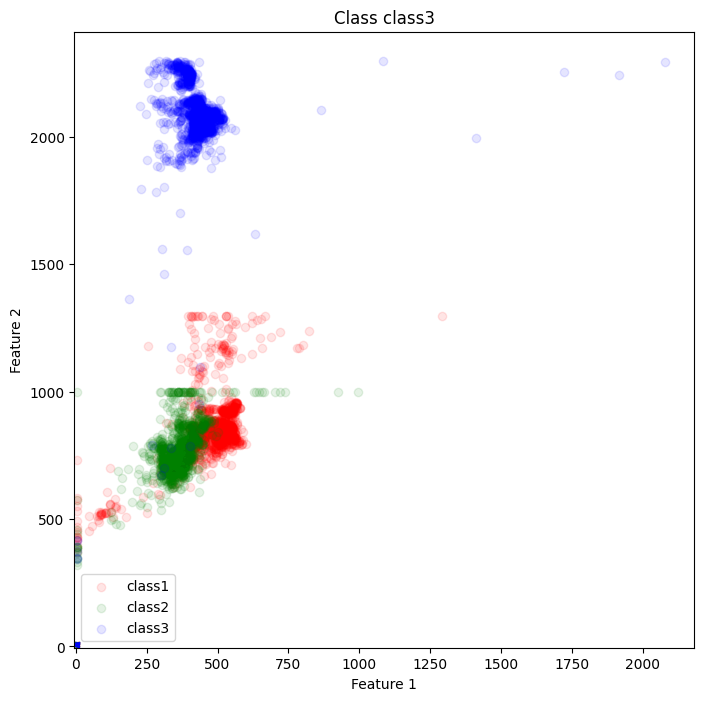

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

Covariance matrix is diagonal and different

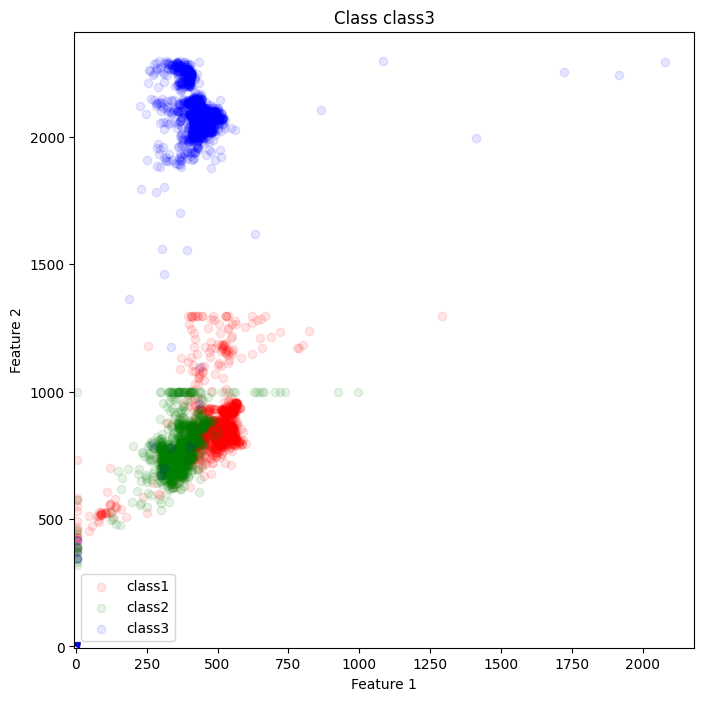

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats_d[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

Covariance matrix is full but same

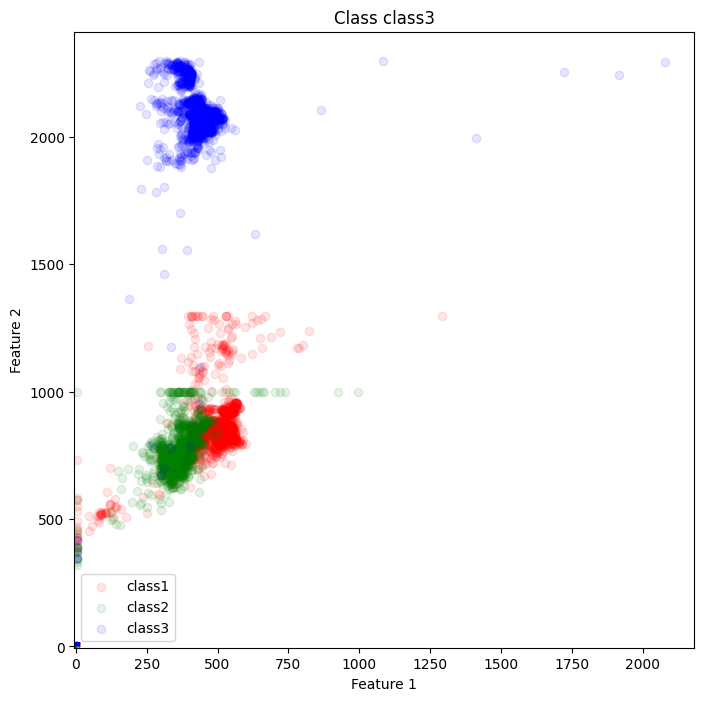

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats_all[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

Covariance matrix is diagonal and same

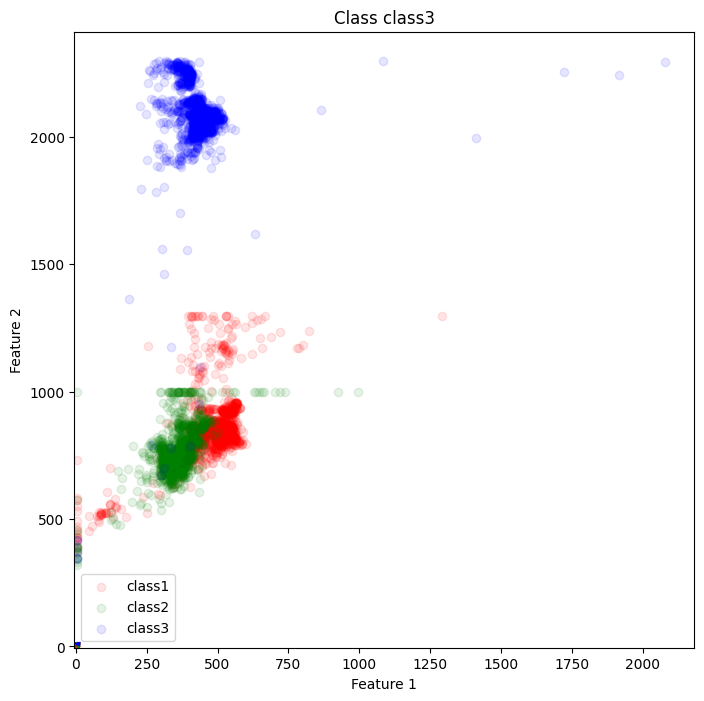

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(means, cov_matrix, ax, label, color):
    # Create grid and multivariate normal distribution
    x, y = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    rv = multivariate_normal([means[0], means[1]], cov_matrix)

    # Plot contour
    ax.contour(x, y, rv.pdf(pos), levels=4, colors=color)
    ax.set_title(f'Class {label}')

df_class_train = {
    'class1': df1_train,
    'class2': df2_train,
    'class3': df3_train
}

fig, ax = plt.subplots(figsize=(8, 8))

# Plot contours and training data for each class
colors = ['red', 'green', 'blue']
labels = ['class1', 'class2', 'class3']

# Superimpose the training data for each class
for i, label in enumerate(labels):
    means, cov_matrix = class_stats_all_d[label]
    plot_contours(means, cov_matrix, ax, label, colors[i])

    # Assuming df_class_train holds training data for each class
    ax.scatter(df_class_train[label][0], df_class_train[label][1], label=label, alpha=0.1, c=colors[i])

# Final plot adjustments
ax.legend()
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

## DECISION REGION PLOT

Covariance matrix is full and different

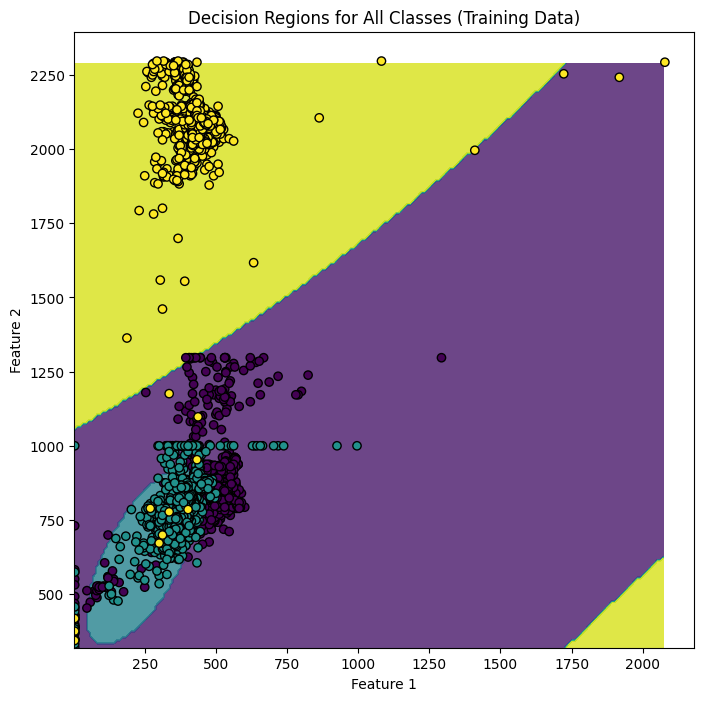

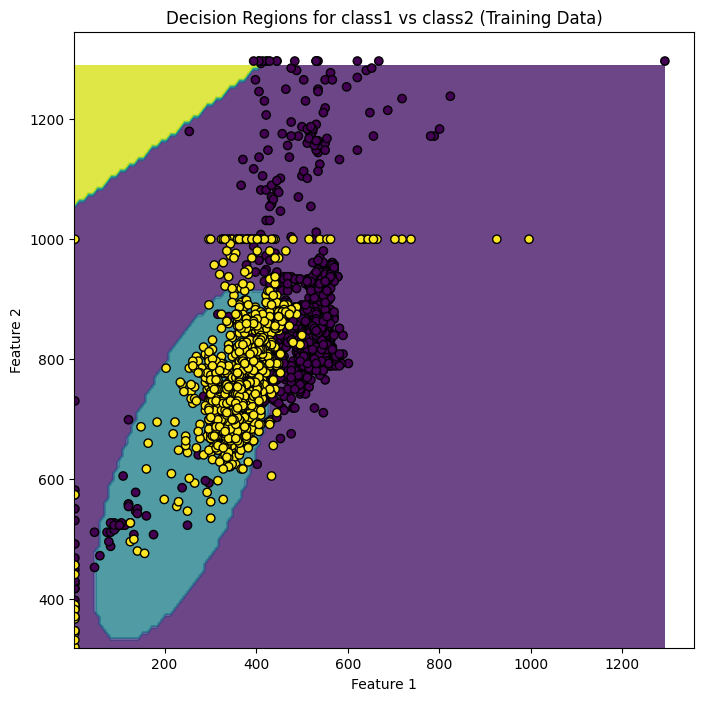

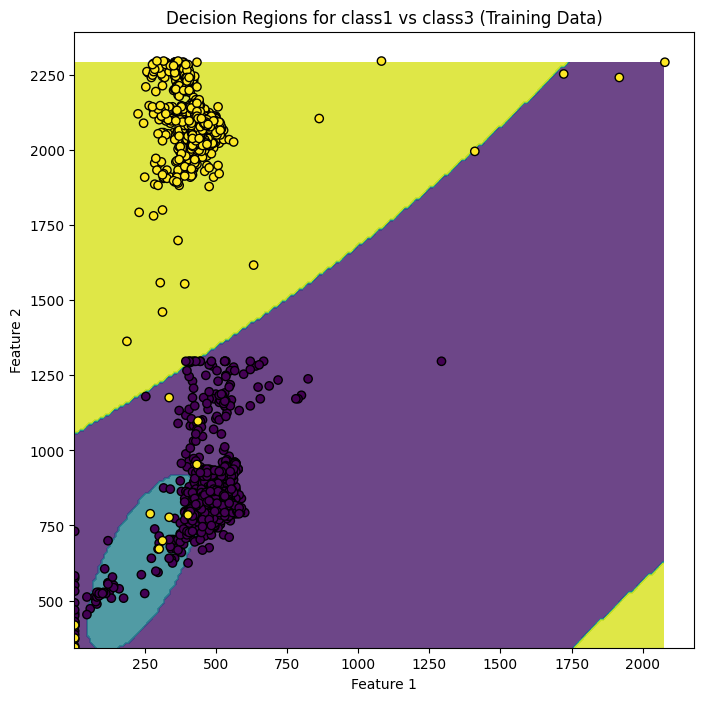

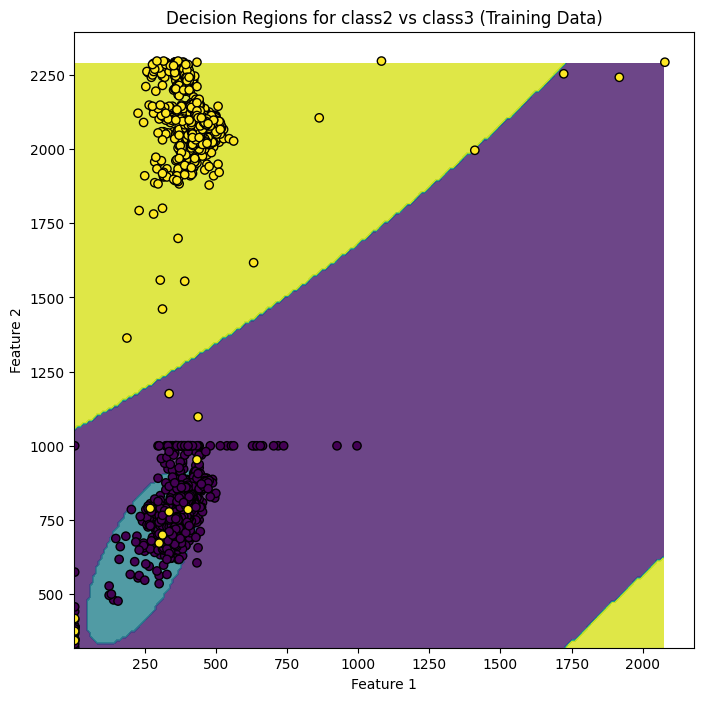

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=10):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()

Covariance matrix is diagonal and different

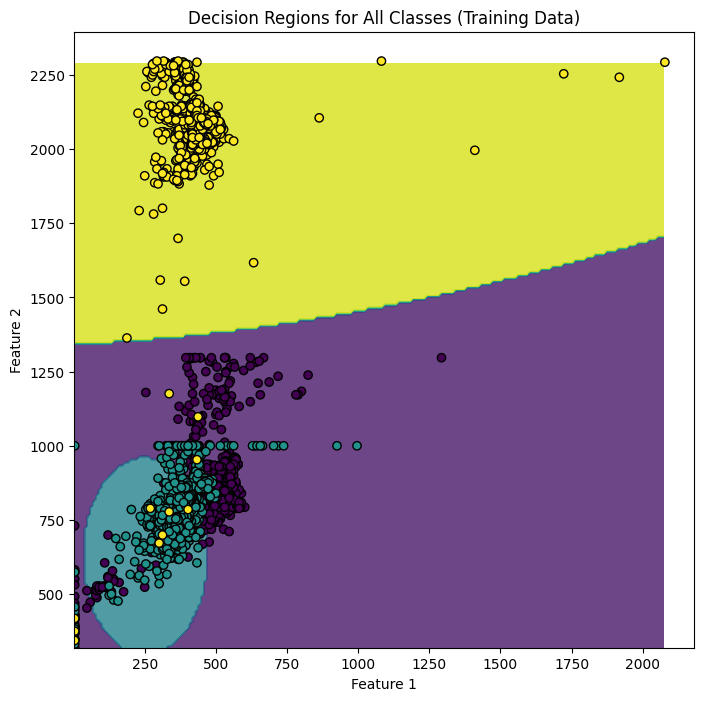

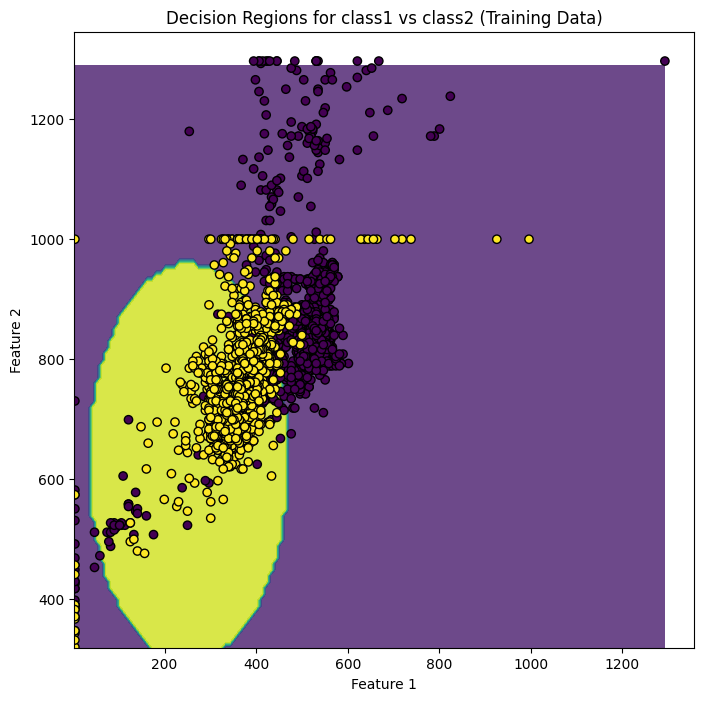

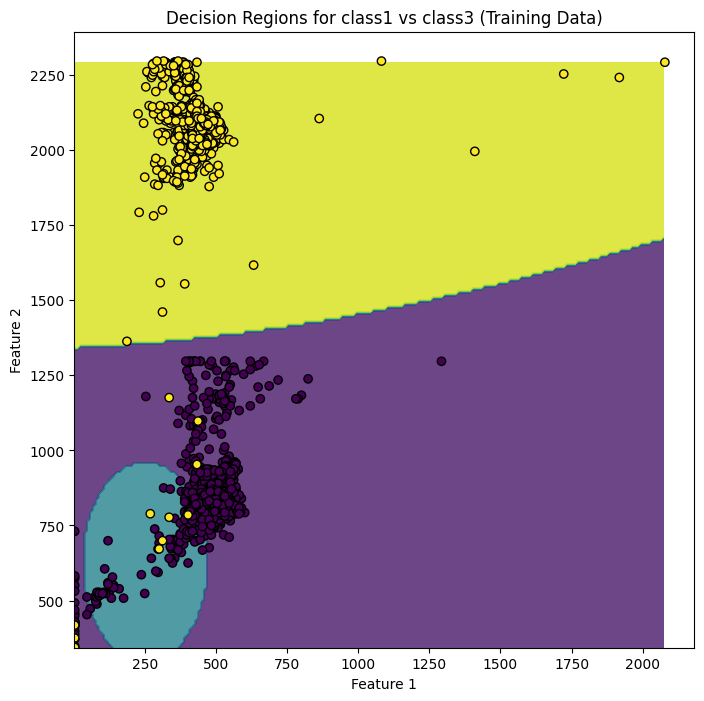

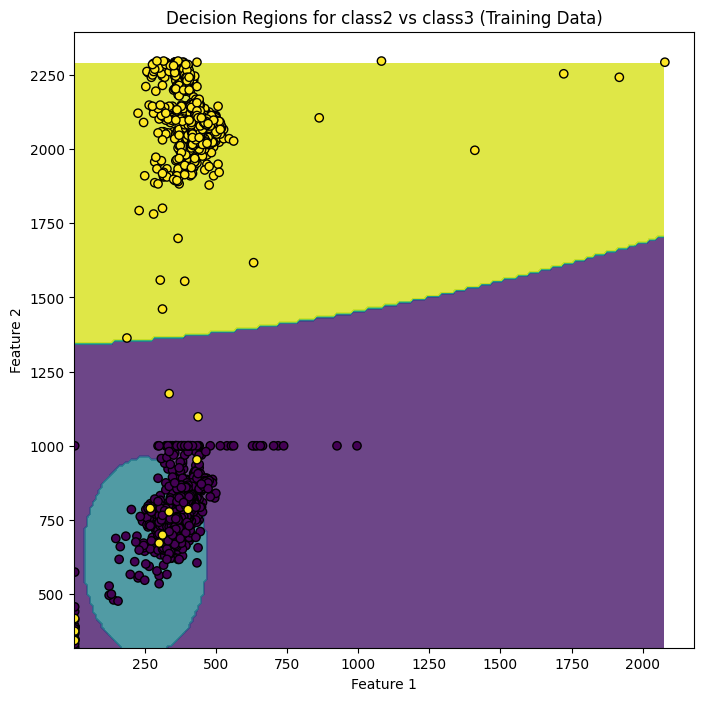

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=10):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()

Covariance matrix is full but same

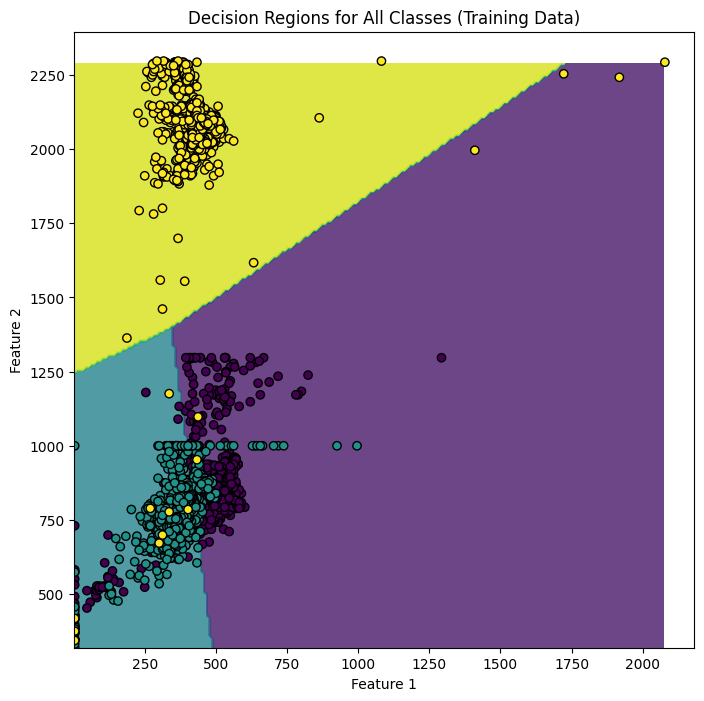

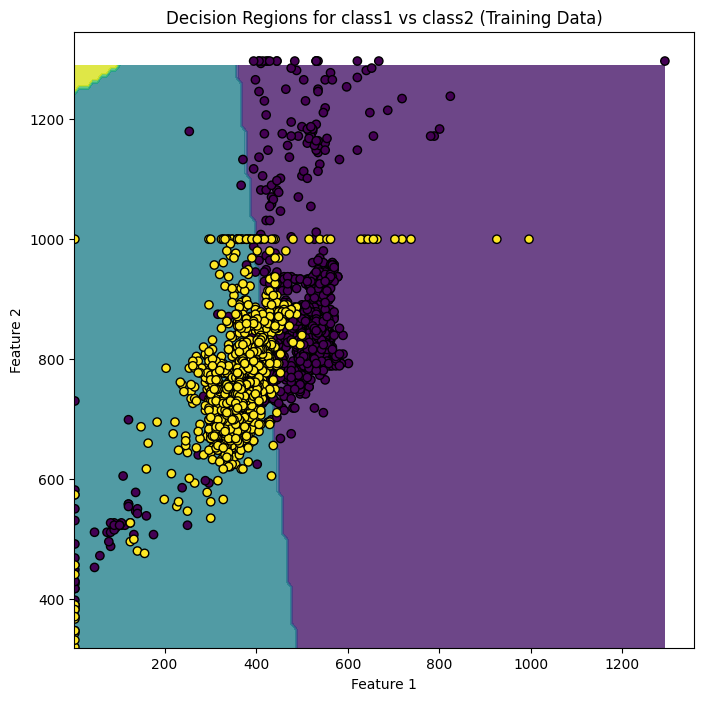

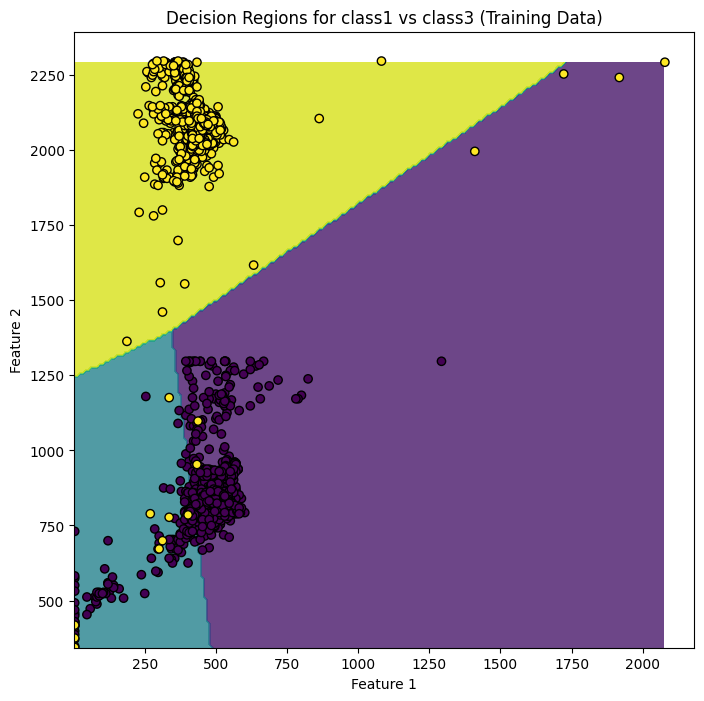

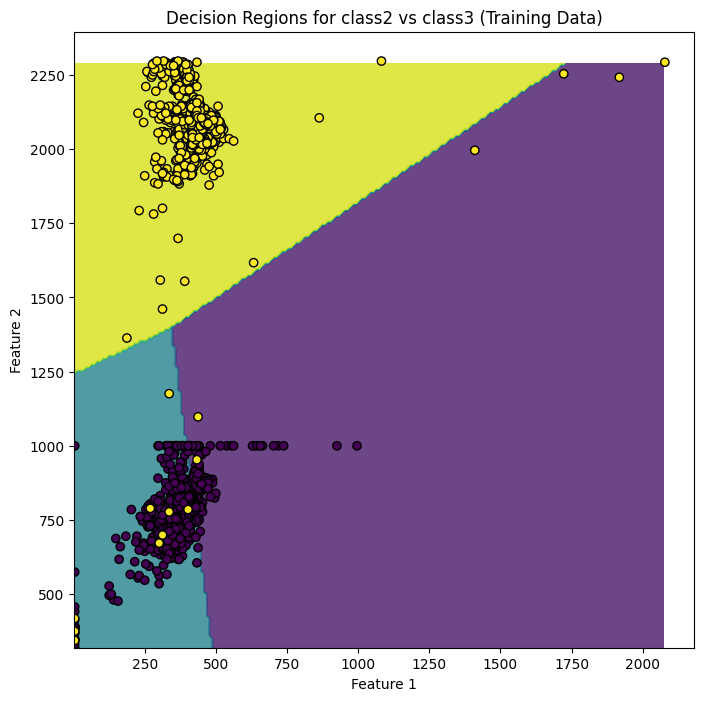

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=10):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats_all, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats_all, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()

Covariance matrix is diagonal and same

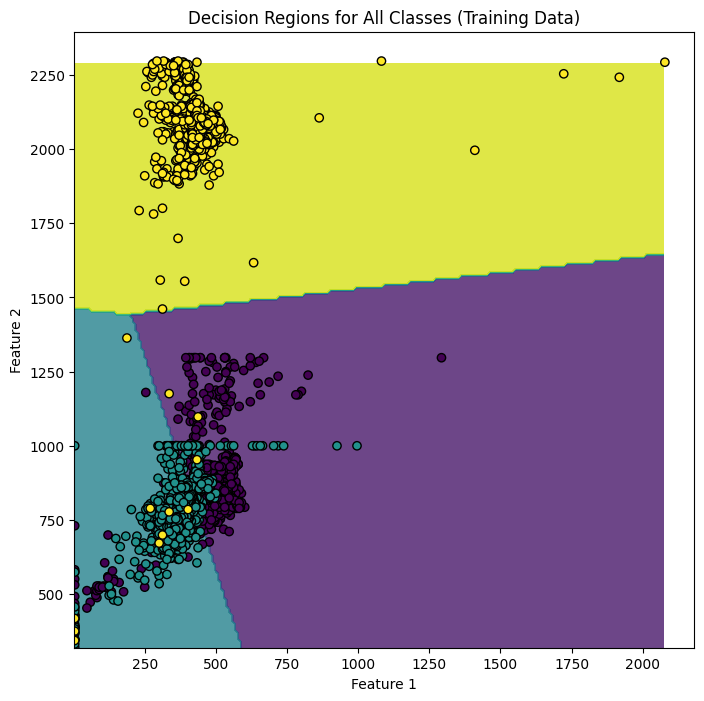

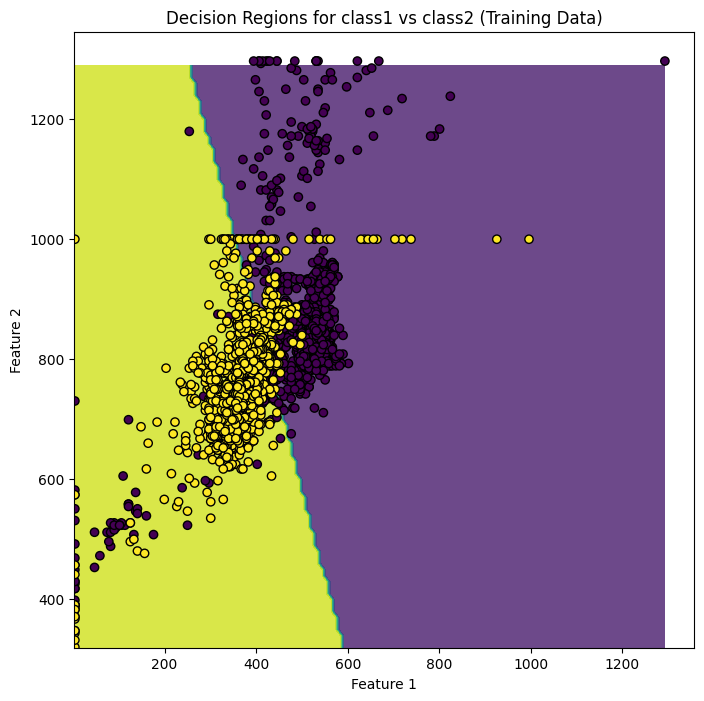

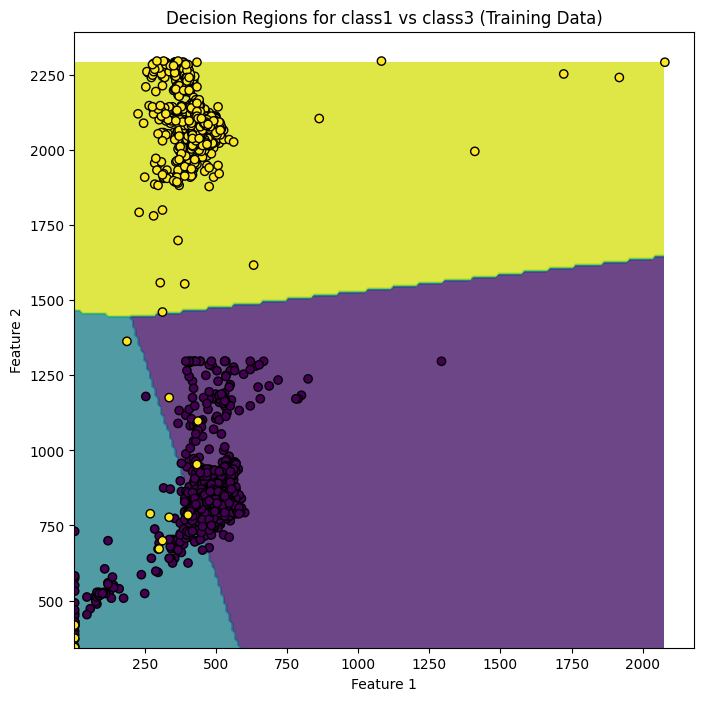

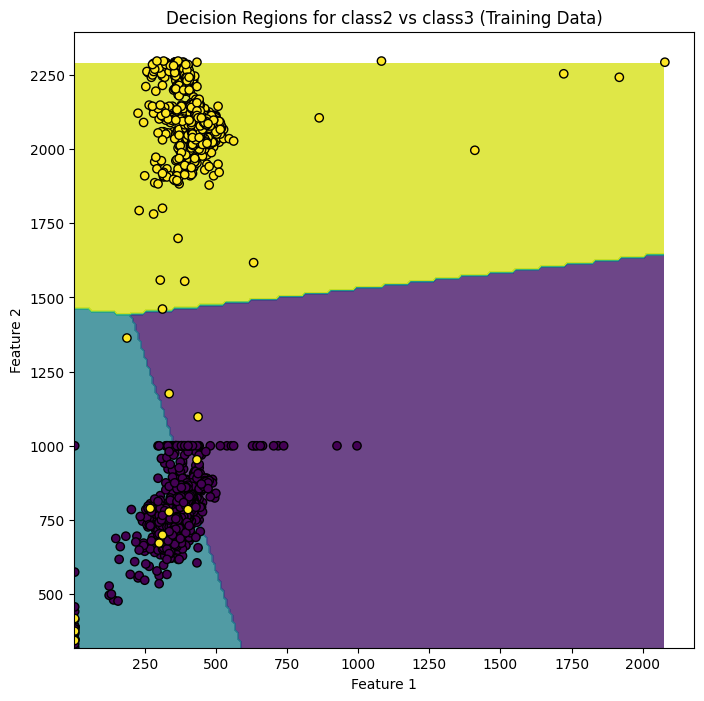

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_class(x_test, class_stats, priors):
    posteriors = calculate_posterior(x_test, class_stats, priors)
    return max(posteriors, key=posteriors.get)

def create_meshgrid(df, step_size=10):
    x_min, x_max = df[0].min() - 1, df[0].max() + 1
    y_min, y_max = df[1].min() - 1, df[1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    return xx, yy

# Combine training data for all classes
df_train_all = pd.concat([df1_train, df2_train, df3_train], ignore_index=True)
df_train_all['class'] = ''
df_train_all.iloc[:len(df1_train), df_train_all.columns.get_loc('class')] = 'class1'
df_train_all.iloc[len(df1_train):len(df1_train)+len(df2_train), df_train_all.columns.get_loc('class')] = 'class2'
df_train_all.iloc[len(df1_train)+len(df2_train):, df_train_all.columns.get_loc('class')] = 'class3'

# Plot decision regions for all classes together
xx, yy = create_meshgrid(df_train_all)
class_mapping = {'class1': 0, 'class2': 1, 'class3': 2}
Z = np.array([predict_class([x, y], class_stats_all_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
Z = np.array([class_mapping[val] for val in Z.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(df_train_all[0], df_train_all[1], c=df_train_all['class'].map({'class1': 0, 'class2': 1, 'class3': 2}), edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Regions for All Classes (Training Data)')
plt.show()

# Plot decision regions for each pair of classes
class_pairs = [('class1', 'class2'), ('class1', 'class3'), ('class2', 'class3')]
for pair in class_pairs:
    class1, class2 = pair
    df_pair = df_train_all[df_train_all['class'].isin(pair)]
    xx, yy = create_meshgrid(df_pair)
    Z = np.array([predict_class([x, y], class_stats_all_d, priors) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = np.array([class_mapping[val] for val in Z.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(df_pair[0], df_pair[1], c=df_pair['class'].map({class1: 0, class2: 1}), edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions for {class1} vs {class2} (Training Data)')
    plt.show()